# Final Notebook

Natasha Kamtekar | nak142

In [1]:
import pandas as pd
import re
import pickle
import nltk
import matplotlib.pyplot as plt
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud

In [2]:
# Formatting
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


First we want to build our pipeline for the classifier. In order to do that we need to unpickle our classifier dataframe.

In [3]:
f = open(r'D:\Documents\Classes\Spring2020\ling1340\Twitter-Positivity-Analysis\data\trainingandtestdata\training.1600000.processed.noemoticon.csv', 'r+')
classify = pd.read_csv(f, index_col=False, names=["polarity", "tweet_id", "date", "query", "username", "text"] ,error_bad_lines=False)

If we switch the sentiment tag from 0/4 to pos/neg, it will be easier to understand.

In [4]:
classify['polarity'].value_counts()
classify = classify.replace(0, "neg")
classify = classify.replace(4, "pos")
classify.tail(5)

4    800000
0    800000
Name: polarity, dtype: int64

,polarity,tweet_id,date,query,username,text
1599995,pos,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,pos,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,pos,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,pos,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,pos,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


### Building the pipeline

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from langdetect import detect
from string import punctuation
from nltk.corpus import stopwords

In [6]:
polarity = classify['polarity']
text = classify['text']
polaritytr, polarityts, texttr, textts = train_test_split(polarity, text, test_size = 0.4, random_state = 0)
tf = TfidfVectorizer(stop_words="english")
nbmodel = make_pipeline(tf, MultinomialNB()) 
nbmodel.fit(texttr, polaritytr)

modelpredict = nbmodel.predict(textts)
accuracy_score(polarityts, modelpredict)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

0.7605375

## Cleaning the Tweets

Now we want to unpickle the tweet dataframes. We will standardize all text to lowercase and remove punctuation so that we can tokenize the text more easily.

In [7]:
f = open('tweets2011.pkl', 'rb')      
tweets2011 = pickle.load(f) 
f.close()

In [8]:
f = open('tweets2019.pkl', 'rb')      
tweets2019 = pickle.load(f) 
f.close() 

In [9]:
tweets2011.text = tweets2011.text.str.lower()
tweets2019.text = tweets2019.text.str.lower()
#stopwords = stopwords.words('english')
nopunc11 = []
tmp11 = []
for t in tweets2011.text:
    try:
        nopunc11 = re.sub(r'[^\w\s]','',t)
        nopunc11 = re.sub(r'https?','',nopunc11)
        nopunc11 = re.sub(r'rt','',nopunc11)
        nopunc11 = re.sub(r'retweet','',nopunc11)
        tmp11.append(nopunc11)
    except: 
        nopunc11 = ''
        tmp11.append(nopunc11)

tweets2011['nopunc'] = tmp11
tweets2011


nopunc19 = []
tmp19 = []
for t in tweets2019.text:
    try:
        nopunc19 = re.sub(r'[^\w\s]','',t)
        nopunc19 = re.sub(r'https?','',nopunc19)
        nopunc19 = re.sub(r'rt','',nopunc19)
        nopunc19 = re.sub(r'retweet','',nopunc19)
        tmp19.append(nopunc19)
    except: 
        nopunc19 = ''
        tmp19.append(nopunc19)

tweets2019['nopunc'] = tmp19
tweets2019

,text,user.lang,created_at,nopunc
0,day & nite,en,Wed Sep 28 03:01:00 +0000 2011,day nite
1,中井ちゃんからの藤田くんだったのに半分のとこで交代したから藤田くん撮れずorz藤田くんからの...,ja,Wed Sep 28 03:01:00 +0000 2011,中井ちゃんからの藤田くんだったのに半分のとこで交代したから藤田くん撮れずorz藤田くんからの...
2,「ツレがうつになりまして。」見たいな。よさそう。,ja,Wed Sep 28 03:01:00 +0000 2011,ツレがうつになりまして見たいなよさそう
3,soy la unica persona que no tiene sueño?,es,Wed Sep 28 03:01:00 +0000 2011,soy la unica persona que no tiene sueño
4,瑞穗实业银行将斥资450亿日元入股越南最大银行: 【共同社9月28日电】日本瑞穗实业银行...,en,Wed Sep 28 03:01:00 +0000 2011,瑞穗实业银行将斥资450亿日元入股越南最大银行 共同社9月28日电日本瑞穗实业银行27日...
...,...,...,...,...
13269,@_benwashere but mate d: colour x),en,Wed Sep 28 03:07:59 +0000 2011,_benwashere but mate d colour x
13270,can it be october already!,en,Wed Sep 28 03:07:59 +0000 2011,can it be october already
13271,"@jsnell it was this phrase ""one of our excitin...",en,Wed Sep 28 03:07:59 +0000 2011,jsnell it was this phrase one of our exciting ...
13272,"read my response to ""what should i do if i wer...",en,Wed Sep 28 03:07:59 +0000 2011,read my response to what should i do if i were...


,text,user.lang,created_at,nopunc
0,雨は憂鬱すぎる。,ja,Wed May 01 06:34:00 +0000 2019,雨は憂鬱すぎる
1,rt: es una de las pocos personas que me hace t...,en,Wed May 01 06:34:00 +0000 2019,es una de las pocos personas que me hace tan ...
2,"@tanya2rl nder sini peluk /? :"")",id,Wed May 01 06:34:00 +0000 2019,tanya2rl nder sini peluk
3,rt: #हिंदुस्तान जिंदाबाद कहने पर #पाकिस्तान...,en,Wed May 01 06:34:00 +0000 2019,हदसतन जदबद कहन पर पकसतन म मत क सज मलत ह\n\...
4,rt: 190501 두시의 데이트❣️\n#황민현 #민현 #minhyun https:...,th,Wed May 01 06:34:00 +0000 2019,190501 두시의 데이트\n황민현 민현 minhyun tcoeoc8jskx
...,...,...,...,...
18326,@oguzhan_tas_ ölüleri öldürdüğümüze göre sıra ...,tr,Wed May 01 06:37:59 +0000 2019,oguzhan_tas_ ölüleri öldürdüğümüze göre sıra y...
18327,"je vous fais découvrir des séries,ou pas🍑 http...",en,Wed May 01 06:37:59 +0000 2019,je vous fais découvrir des sériesou pas tcoidq...
18328,@glitterfoof i hear ta rachie https://t.co/ydm...,en,Wed May 01 06:37:59 +0000 2019,glitterfoof i hear ta rachie tcoydmyafjmnw
18329,は？w https://t.co/hwujmjwvvp,ja,Wed May 01 06:37:59 +0000 2019,はw tcohwujmjwvvp


The text is in lowercase and not punctuated, but there are too many non-English tweets! Let's fix this by using langdetect. The next two cells are predicting the language and appending it to the dataframe.

In [10]:
#Predicting language
i = 0
lng11 = pd.DataFrame()
while True: 
    try:
        #tweets2011.loc[i, "text"] = re.sub(r'(?:(@|&|;|http|https)[\w_]+)', '', tweets2011.loc[i, "text"]) #cleaning
        tmp = pd.DataFrame({'languages': [detect(tweets2011.loc[i, "nopunc"])]}) 
        lng11 = lng11.append(tmp, sort=False, ignore_index=True)
        if i > len(tweets2011):
            break
        i = i+1
    except:
        tmp = pd.DataFrame({'languages': ["error"]}) #If the language is not able to be predicted
        lng11 = lng11.append(tmp, sort=False, ignore_index=True)
        if i > len(tweets2011):
            break
        i = i+1

In [11]:
# This is the same as above, but for 2019
i = 0
lng19 = pd.DataFrame()
while True: 
    try:
        #tweets2019.loc[i, "text"] = re.sub(r'(?:@[\w_]+)', '', tweets2019.loc[i, "text"])
        tmp = pd.DataFrame({'languages': [detect(tweets2019.loc[i, "nopunc"])]})
        lng19 = lng19.append(tmp, sort=False, ignore_index=True)
        if i > len(tweets2019):
            break
        i = i+1
    except:
        tmp = pd.DataFrame({'languages': ["error"]})
        lng19 = lng19.append(tmp, sort=False, ignore_index=True)
        if i > len(tweets2019):
            break
        i = i+1


In [12]:
tweets2011['languages'] = lng11
tweets2019['languages'] = lng19

In [13]:
tweets2011 = tweets2011[tweets2011['languages'] == 'en']
print("Length of 2011 dataset:", len(tweets2011))
#tweets2011.reset_index()

tweets2019 = tweets2019[tweets2019['languages'] == 'en']
print("Length of 2019 dataset:",len(tweets2019))
#tweets2019.reset_index()

Length of 2011 dataset: 5360
Length of 2019 dataset: 4917


The length of the dataframes has dropped since we shed all non-English tweets. Now we will use the NB classifier we built earlier to categorize the tweets into positive and negative.

## Sentiment

In [14]:
tmp11 = []
for t in tweets2011.nopunc:
    tmp11.append("".join(nbmodel.predict([t]).tolist()))
    i = i+1
    
tmp19 = []
for p in tweets2019.nopunc:
    tmp19.append("".join(nbmodel.predict([p]).tolist()))
    i = i+1

In [15]:
tweets2011["polarity"] = tmp11
tweets2011.reindex()
tweets2019["polarity"] = tmp19
tweets2019.reindex()


D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,user.lang,created_at,nopunc,languages,polarity
5,@forevertawny: yes:) are you busy thursday or...,en,Wed Sep 28 03:01:00 +0000 2011,foreveawny yes are you busy thursday or frida...,en,pos
7,i'm your friend. (^___^) rt i got absolutely 0...,en,Wed Sep 28 03:01:00 +0000 2011,im your friend ___ i got absolutely 0 friends,en,pos
8,so.many.things.happening........ #omg #hurryhu...,en,Wed Sep 28 03:01:00 +0000 2011,somanythingshappening omg hurryhurrynexttuesday,en,neg
11,okay time for me too go too sleep.,en,Wed Sep 28 03:01:00 +0000 2011,okay time for me too go too sleep,en,neg
16,"@lilmamacita0501 lol nun bad,, it's pose ta b ...",en,Wed Sep 28 03:01:00 +0000 2011,lilmamacita0501 lol nun bad its pose ta b thar...,en,pos
...,...,...,...,...,...,...
13266,rt: read this and sigh/weep/giggle/sigh again....,en,Wed Sep 28 03:07:59 +0000 2011,read this and sighweepgigglesigh again tco4ms...,en,pos
13269,@_benwashere but mate d: colour x),en,Wed Sep 28 03:07:59 +0000 2011,_benwashere but mate d colour x,en,pos
13270,can it be october already!,en,Wed Sep 28 03:07:59 +0000 2011,can it be october already,en,neg
13271,"@jsnell it was this phrase ""one of our excitin...",en,Wed Sep 28 03:07:59 +0000 2011,jsnell it was this phrase one of our exciting ...,en,pos


D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,user.lang,created_at,nopunc,languages,polarity
7,rt: wtf https://t.co/lidgzlkvbp,en,Wed May 01 06:34:00 +0000 2019,wtf tcolidgzlkvbp,en,neg
8,rt: when u know robert mueller is watching u l...,en,Wed May 01 06:34:00 +0000 2019,when u know robe mueller is watching u lie tc...,en,pos
10,please help me get to 10 or 20 rt ... i want a...,en,Wed May 01 06:34:00 +0000 2019,please help me get to 10 or 20 i want an acc...,en,neg
14,rt: high school: college isn’t a joke\ncollege...,en,Wed May 01 06:34:00 +0000 2019,high school college isnt a joke\ncollege tcon...,en,neg
16,rt:'s video sums up labour's decision yesterda...,en,Wed May 01 06:34:00 +0000 2019,s video sums up labours decision yesterday \nh...,en,neg
...,...,...,...,...,...,...
18321,@chyke777 your sentence makes it seem as thoug...,en,Wed May 01 06:37:59 +0000 2019,chyke777 your sentence makes it seem as though...,en,pos
18322,rt: not from yoruba men sha. their mum likes e...,en,Wed May 01 06:37:59 +0000 2019,not from yoruba men sha their mum likes every...,en,pos
18324,rt: what the fuck is she gaining from this????...,en,Wed May 01 06:37:59 +0000 2019,what the fuck is she gaining from this i hate...,en,neg
18325,"rt: winner comeback, coming soon https://t.co/...",en,Wed May 01 06:37:59 +0000 2019,winner comeback coming soon tcogopth18zug,en,pos


Polarity values for 2011
 neg    2873
pos    2487
Name: polarity, dtype: int64


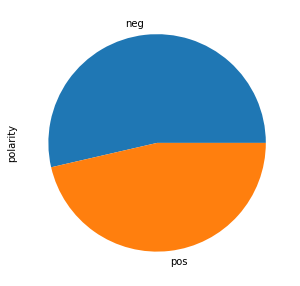

In [16]:
pie11 = tweets2011['polarity'].value_counts()
pie19 = tweets2019['polarity'].value_counts()
print("Polarity values for 2011\n",tweets2011['polarity'].value_counts())
pie11.plot.pie(figsize=(5, 5))

Polarity values for 2019
 neg    2616
pos    2301
Name: polarity, dtype: int64


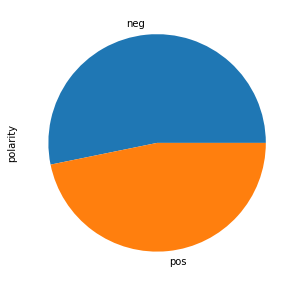

In [17]:
print("Polarity values for 2019\n",tweets2019['polarity'].value_counts())
pie19.plot.pie(figsize=(5, 5))

Looks like an even split! Now we want to create tokens, bigrams, and trigrams in order to analyze lexical complexity.

## Lexical Complexity

In [18]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
tokens11 = tweets2011.nopunc.map(nltk.word_tokenize)
tokens19 = tweets2019.nopunc.map(nltk.word_tokenize)
tweets2011['stop_toks'] = tokens11
tweets2019['stop_toks'] = tokens19

wordlen11 = tweets2011.stop_toks.map(lambda x: [len(word) for word in x])
wordlen19 = tweets2019.stop_toks.map(lambda x: [len(word) for word in x])
tweets2011['word_len'] = wordlen11
tweets2019['word_len'] = wordlen19


len11 = tweets2011.stop_toks.map(len)
len19 = tweets2019.stop_toks.map(len)
tweets2011['tweet_len'] = len11
tweets2019['tweet_len'] = len19

bigrams11 = tweets2011.stop_toks.map(nltk.bigrams)
bigrams19 = tweets2019.stop_toks.map(nltk.bigrams)
bi11lst = []
tmp11 = []
for x in bigrams11:
    for y in x:
        tmp11.append(y)
    bi11lst.append(tmp11)
    tmp11 = []
bi19lst = []
tmp19 = []
for x in bigrams19:
    for y in x:
        tmp19.append(y)
    bi19lst.append(tmp19)
    tmp19 = []
tweets2011['bigrams'] = bi11lst
tweets2019['bigrams'] = bi19lst

tri11 = tweets2011.stop_toks.map(lambda x: nltk.ngrams(x, 3))
tri19 = tweets2019.stop_toks.map(lambda x: nltk.ngrams(x, 3))
tri11lst = []
tmp11 = []
for x in tri11:
    for y in x:
        tmp11.append(y)
    tri11lst.append(tmp11)
    tmp11 = []
tri19lst = []
tmp19 = []
for x in tri19:
    for y in x:
        tmp19.append(y)
    tri19lst.append(tmp19)
    tmp19 = []
tweets2011['trigrams'] = tri11lst
tweets2019['trigrams'] = tri19lst

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [19]:
tweets2011
tweets2019

,text,user.lang,created_at,nopunc,languages,polarity,stop_toks,word_len,tweet_len,bigrams,trigrams
5,@forevertawny: yes:) are you busy thursday or...,en,Wed Sep 28 03:01:00 +0000 2011,foreveawny yes are you busy thursday or frida...,en,pos,"[foreveawny, yes, are, you, busy, thursday, or...","[10, 3, 3, 3, 4, 8, 2, 6, 3, 4, 3, 4, 7, 3, 5, 5]",16,"[(foreveawny, yes), (yes, are), (are, you), (y...","[(foreveawny, yes, are), (yes, are, you), (are..."
7,i'm your friend. (^___^) rt i got absolutely 0...,en,Wed Sep 28 03:01:00 +0000 2011,im your friend ___ i got absolutely 0 friends,en,pos,"[im, your, friend, ___, i, got, absolutely, 0,...","[2, 4, 6, 3, 1, 3, 10, 1, 7]",9,"[(im, your), (your, friend), (friend, ___), (_...","[(im, your, friend), (your, friend, ___), (fri..."
8,so.many.things.happening........ #omg #hurryhu...,en,Wed Sep 28 03:01:00 +0000 2011,somanythingshappening omg hurryhurrynexttuesday,en,neg,"[somanythingshappening, omg, hurryhurrynexttue...","[21, 3, 21]",3,"[(somanythingshappening, omg), (omg, hurryhurr...","[(somanythingshappening, omg, hurryhurrynexttu..."
11,okay time for me too go too sleep.,en,Wed Sep 28 03:01:00 +0000 2011,okay time for me too go too sleep,en,neg,"[okay, time, for, me, too, go, too, sleep]","[4, 4, 3, 2, 3, 2, 3, 5]",8,"[(okay, time), (time, for), (for, me), (me, to...","[(okay, time, for), (time, for, me), (for, me,..."
16,"@lilmamacita0501 lol nun bad,, it's pose ta b ...",en,Wed Sep 28 03:01:00 +0000 2011,lilmamacita0501 lol nun bad its pose ta b thar...,en,pos,"[lilmamacita0501, lol, nun, bad, its, pose, ta...","[15, 3, 3, 3, 3, 4, 2, 1, 5, 2, 3, 3, 1, 3]",14,"[(lilmamacita0501, lol), (lol, nun), (nun, bad...","[(lilmamacita0501, lol, nun), (lol, nun, bad),..."
...,...,...,...,...,...,...,...,...,...,...,...
13266,rt: read this and sigh/weep/giggle/sigh again....,en,Wed Sep 28 03:07:59 +0000 2011,read this and sighweepgigglesigh again tco4ms...,en,pos,"[read, this, and, sighweepgigglesigh, again, t...","[4, 4, 3, 18, 5, 11, 4, 10, 9, 3, 7, 2, 3, 6]",14,"[(read, this), (this, and), (and, sighweepgigg...","[(read, this, and), (this, and, sighweepgiggle..."
13269,@_benwashere but mate d: colour x),en,Wed Sep 28 03:07:59 +0000 2011,_benwashere but mate d colour x,en,pos,"[_benwashere, but, mate, d, colour, x]","[11, 3, 4, 1, 6, 1]",6,"[(_benwashere, but), (but, mate), (mate, d), (...","[(_benwashere, but, mate), (but, mate, d), (ma..."
13270,can it be october already!,en,Wed Sep 28 03:07:59 +0000 2011,can it be october already,en,neg,"[can, it, be, october, already]","[3, 2, 2, 7, 7]",5,"[(can, it), (it, be), (be, october), (october,...","[(can, it, be), (it, be, october), (be, octobe..."
13271,"@jsnell it was this phrase ""one of our excitin...",en,Wed Sep 28 03:07:59 +0000 2011,jsnell it was this phrase one of our exciting ...,en,pos,"[jsnell, it, was, this, phrase, one, of, our, ...","[6, 2, 3, 4, 6, 3, 2, 3, 8, 8, 6, 9, 4, 3, 2, ...",21,"[(jsnell, it), (it, was), (was, this), (this, ...","[(jsnell, it, was), (it, was, this), (was, thi..."


,text,user.lang,created_at,nopunc,languages,polarity,stop_toks,word_len,tweet_len,bigrams,trigrams
7,rt: wtf https://t.co/lidgzlkvbp,en,Wed May 01 06:34:00 +0000 2019,wtf tcolidgzlkvbp,en,neg,"[wtf, tcolidgzlkvbp]","[3, 13]",2,"[(wtf, tcolidgzlkvbp)]",[]
8,rt: when u know robert mueller is watching u l...,en,Wed May 01 06:34:00 +0000 2019,when u know robe mueller is watching u lie tc...,en,pos,"[when, u, know, robe, mueller, is, watching, u...","[4, 1, 4, 4, 7, 2, 8, 1, 3, 13]",10,"[(when, u), (u, know), (know, robe), (robe, mu...","[(when, u, know), (u, know, robe), (know, robe..."
10,please help me get to 10 or 20 rt ... i want a...,en,Wed May 01 06:34:00 +0000 2019,please help me get to 10 or 20 i want an acc...,en,neg,"[please, help, me, get, to, 10, or, 20, i, wan...","[6, 4, 2, 3, 2, 2, 2, 2, 1, 4, 2, 7, 4, 5, 4]",15,"[(please, help), (help, me), (me, get), (get, ...","[(please, help, me), (help, me, get), (me, get..."
14,rt: high school: college isn’t a joke\ncollege...,en,Wed May 01 06:34:00 +0000 2019,high school college isnt a joke\ncollege tcon...,en,neg,"[high, school, college, isnt, a, joke, college...","[4, 6, 7, 4, 1, 4, 7, 13]",8,"[(high, school), (school, college), (college, ...","[(high, school, college), (school, college, is..."
16,rt:'s video sums up labour's decision yesterda...,en,Wed May 01 06:34:00 +0000 2019,s video sums up labours decision yesterday \nh...,en,neg,"[s, video, sums, up, labours, decision, yester...","[1, 5, 4, 2, 7, 8, 9, 2, 4, 6, 11, 6, 3, 4, 3,...",17,"[(s, video), (video, sums), (sums, up), (up, l...","[(s, video, sums), (video, sums, up), (sums, u..."
...,...,...,...,...,...,...,...,...,...,...,...
18321,@chyke777 your sentence makes it seem as thoug...,en,Wed May 01 06:37:59 +0000 2019,chyke777 your sentence makes it seem as though...,en,pos,"[chyke777, your, sentence, makes, it, seem, as...","[8, 4, 8, 5, 2, 4, 2, 6, 4, 2, 9, 4, 4, 6, 2, ...",20,"[(chyke777, your), (your, sentence), (sentence...","[(chyke777, your, sentence), (your, sentence, ..."
18322,rt: not from yoruba men sha. their mum likes e...,en,Wed May 01 06:37:59 +0000 2019,not from yoruba men sha their mum likes every...,en,pos,"[not, from, yoruba, men, sha, their, mum, like...","[3, 4, 6, 3, 3, 5, 3, 5, 9, 13]",10,"[(not, from), (from, yoruba), (yoruba, men), (...","[(not, from, yoruba), (from, yoruba, men), (yo..."
18324,rt: what the fuck is she gaining from this????...,en,Wed May 01 06:37:59 +0000 2019,what the fuck is she gaining from this i hate...,en,neg,"[what, the, fuck, is, she, gaining, from, this...","[4, 3, 4, 2, 3, 7, 4, 4, 1, 4, 5, 8, 4, 5, 3, ...",18,"[(what, the), (the, fuck), (fuck, is), (is, sh...","[(what, the, fuck), (the, fuck, is), (fuck, is..."
18325,"rt: winner comeback, coming soon https://t.co/...",en,Wed May 01 06:37:59 +0000 2019,winner comeback coming soon tcogopth18zug,en,pos,"[winner, comeback, coming, soon, tcogopth18zug]","[6, 8, 6, 4, 13]",5,"[(winner, comeback), (comeback, coming), (comi...","[(winner, comeback, coming), (comeback, coming..."


## Graphing

This next section is creating flat lists of all the frequency distrubutions so that they can easily be put into graphs and word clouds. The most common unigrams/bigrams/trigrams are displayed under each cell.

In [20]:
flat3gram11 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat3gram11.append(i) 
reemovNestings(tweets2011.trigrams.tolist())

from collections import Counter
tricount11 = Counter(flat3gram11)
tricount11.most_common(5)

[(('a', 'better', 'you'), 24), (('i', 'want', 'to'), 21), (('i', 'wan', 'na'), 21), (('i', 'love', 'you'), 20), (('gon', 'na', 'be'), 19)]

In [21]:
flat3gram19 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat3gram19.append(i) 
reemovNestings(tweets2019.trigrams.tolist())

from collections import Counter
tricount19 = Counter(flat3gram19)
tricount19.most_common(5)

[(('1', '1', 'vote'), 31), (('1', 'vote', '1'), 31), (('one', 'of', 'the'), 24), (('reply', 'with', 'bbmastopsocial'), 23), (('me', 'automatically', 'checked'), 23)]

In [22]:
flat2gram11 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat2gram11.append(i) 
reemovNestings(tweets2011.bigrams.tolist())

from collections import Counter
bicount11 = Counter(flat2gram11)
bicount11.most_common(5)

[(('in', 'the'), 114), (('if', 'you'), 91), (('i', 'dont'), 82), (('to', 'be'), 80), (('i', 'love'), 74)]

In [23]:
flat2gram19 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat2gram19.append(i) 
reemovNestings(tweets2019.bigrams.tolist())

from collections import Counter
bicount19 = Counter(flat2gram19)
bicount19.most_common(5)

[(('bbmastopsocial', 'bts'), 258), (('of', 'the'), 131), (('in', 'the'), 124), (('this', 'is'), 100), (('to', 'the'), 94)]

In [24]:
flat1gram11 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat1gram11.append(i) 
reemovNestings(tweets2011.stop_toks.tolist())

from collections import Counter
count11 = Counter(flat1gram11)
count11.most_common(5)

[('i', 1803), ('to', 1423), ('the', 1296), ('you', 1132), ('a', 1036)]

In [25]:
flat1gram19 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat1gram19.append(i) 
reemovNestings(tweets2019.stop_toks.tolist())

from collections import Counter
count19 = Counter(flat1gram19)
count19.most_common(5)

[('the', 1794), ('to', 1404), ('a', 1098), ('and', 947), ('i', 917)]

Now we are going to take a look at word clouds! These clouds are the most common ngrams from 2011 and 2019 respectively. 

(-0.5, 399.5, 199.5, -0.5)

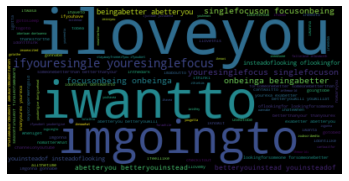

In [26]:
# Start with one review:
tmp = []
text = ""
for t in flat3gram11:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

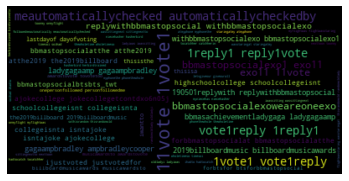

In [27]:
# Start with one review:
tmp = []
text = ""
for t in flat3gram19:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

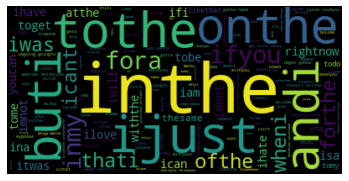

In [28]:
# Start with one review:
tmp = []
text = ""
for t in flat2gram11:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

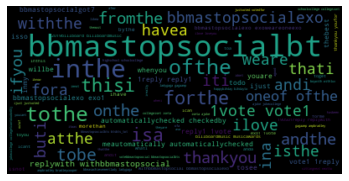

In [29]:
# Start with one review:
tmp = []
text = ""
for t in flat2gram19:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

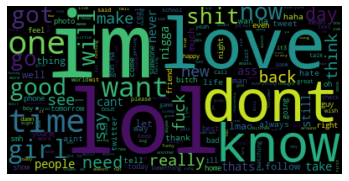

In [30]:
# Start with one review:
tmp = []
text = ""
for t in flat1gram11:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

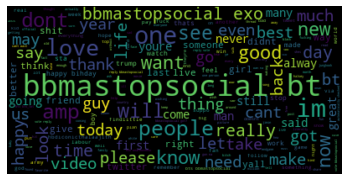

In [31]:
# Start with one review:
tmp = []
text = ""
for t in flat1gram19:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looking at TTR breakdown. These are the ratios for different ngrams.

Type-token ratio for 2011 bigrams: 0.69
Type-token ratio for 2019 bigrams: 0.68


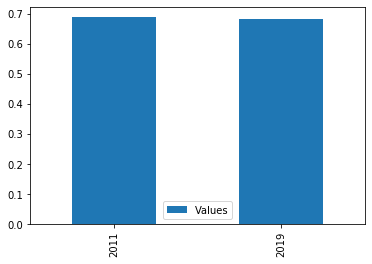

In [32]:
flatbi11 = flat2gram11
bfd11 = nltk.FreqDist(flatbi11)

types = list(bfd11.keys())
ttr11 = len(types)/len(flatbi11)
print("Type-token ratio for 2011 bigrams:",round(ttr11, 2))

flatbi19 = flat2gram19
bfd19 = nltk.FreqDist(flatbi19)

types = list(bfd19.keys())
ttr19 = len(types)/len(flatbi19)
print("Type-token ratio for 2019 bigrams:",round(ttr19,2))

biline =  pd.Series([round(ttr11, 3), round(ttr19, 3)])
df2 = pd.DataFrame({'Values' : [biline[0], biline[1]]}, index=['2011', '2019'])
df2.plot.bar()

Type-token ratio for 2011 trigrams: 0.92
Type-token ratio for 2019 trigrams: 0.86


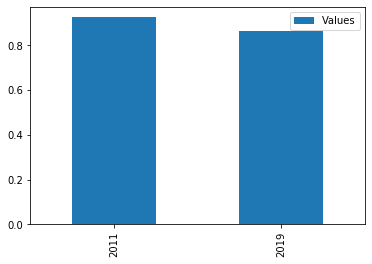

In [33]:
flattri11 = flat3gram11
tfd11 = nltk.FreqDist(flattri11)

types = list(tfd11.keys())
ttr11 = len(types)/len(flattri11)
print("Type-token ratio for 2011 trigrams:",round(ttr11,2))

flattri19 = flat3gram19
tfd19 = nltk.FreqDist(flattri19)

types = list(tfd19.keys())
ttr19 = len(types)/len(flattri19)
print("Type-token ratio for 2019 trigrams:",round(ttr19,2))

triline =  pd.Series([round(ttr11, 3), round(ttr19, 3)])
df3 = pd.DataFrame({'Values' : [triline[0], triline[1]]}, index=['2011', '2019'])
df3.plot.bar()

Type-token ratio for 2011 unigrams: 0.2
Type-token ratio for 2019 unigrams: 0.23


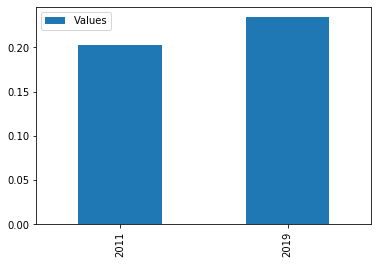

In [34]:
flat11 = flat1gram11
fd11 = nltk.FreqDist(flat11)

types = list(fd11.keys())
ttr11 = len(types)/len(flat11)
print("Type-token ratio for 2011 unigrams:",round(ttr11,2))


flat19 = flat1gram19
fd19 = nltk.FreqDist(flat19)

types = list(fd19.keys())
ttr19 = len(types)/len(flat19)
print("Type-token ratio for 2019 unigrams:",round(ttr19,2))

line = pd.Series([round(ttr11, 3), round(ttr19, 3)])
df1 = pd.DataFrame({'Values' : [line[0], line[1]]}, index=['2011', '2019'])
df1.plot.bar()

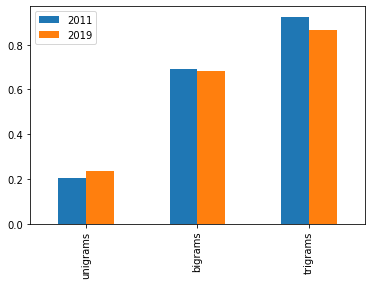

In [35]:
index = [2011, 2019]
df = pd.DataFrame({'2011' : [line[0], biline[0], triline[0]], '2019' : [line[1], biline[1], triline[1]]}, index=['unigrams','bigrams','trigrams'] )
ax = df.plot.bar()

Here is an nltk classifier in order to see what some of the most common features of the 2011 and 2019 tweets are.

In [36]:
word_features = list(dict(fd11.most_common(5000)).keys())
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features
posdf = tweets2011[tweets2011.polarity == "pos"]
negdf = tweets2011[tweets2011.polarity == "neg"]
postup = [(x, "pos") for x in posdf.stop_toks]
negtup = [(x, "neg") for x in negdf.stop_toks]
tup = postup+negtup
featuresets = [(document_features(d), c) for (d,c) in tup]

In [37]:
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.78

Frequency distrubution of certain topical words for 2011 and 2019. Followed by general most common ngrams.

In [38]:
fd19['bts']
classifier.classify(document_features("bts"))

fd19['avengers']
classifier.classify(document_features("avengers"))

fd19['venezuela']
classifier.classify(document_features("venezuela"))

fd19['trump']
classifier.classify(document_features("trump"))

fd19['obama']
classifier.classify(document_features("obama"))

fd19['bernie']
classifier.classify(document_features("bernie"))

bfd19['hong', 'kong']
classifier.classify(document_features("hong kong"))

fd19['gay']
classifier.classify(document_features("gay"))

406

'neg'

21

'pos'

14

'pos'

36

'pos'

3

'neg'

3

'pos'

1

'neg'

5

'neg'

In [39]:
bfd11
bfd19

FreqDist({('in', 'the'): 114, ('if', 'you'): 91, ('i', 'dont'): 82, ('to', 'be'): 80, ('i', 'love'): 74, ('wan', 'na'): 69, ('i', 'just'): 67, ('i', 'know'): 64, ('to', 'the'): 63, ('gon', 'na'): 61, ...})

FreqDist({('bbmastopsocial', 'bts'): 258, ('of', 'the'): 131, ('in', 'the'): 124, ('this', 'is'): 100, ('to', 'the'): 94, ('bbmastopsocial', 'exo'): 92, ('on', 'the'): 85, ('if', 'you'): 80, ('to', 'be'): 74, ('is', 'a'): 70, ...})

In [40]:
fd11.most_common(5)
fd19.most_common(5)

[('i', 1803), ('to', 1423), ('the', 1296), ('you', 1132), ('a', 1036)]

[('the', 1794), ('to', 1404), ('a', 1098), ('and', 947), ('i', 917)]

Looking at min and max tweet length and word length. 

11.355970149253732

12.693919056335163

31

1

30

1

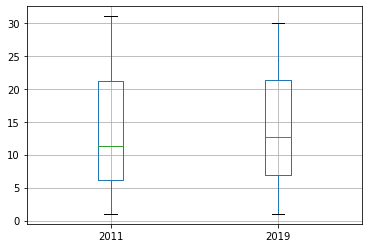

In [41]:
avglen11 = sum(tweets2011.tweet_len)/len(tweets2011.tweet_len)
avglen19 = sum(tweets2019.tweet_len)/len(tweets2019.tweet_len)
avglen11
avglen19

max11 = max(tweets2011.tweet_len)
min11 = min(tweets2011.tweet_len)

max19 = max(tweets2019.tweet_len)
min19 = min(tweets2019.tweet_len)

df = pd.DataFrame({'2011' : [avglen11, max11, min11], '2019' : [avglen19, max19, min19]}, index=['Average Tweet Length','Max Tweet Length','Min Tweet Length'] )
ax = df.boxplot()

max11 
min11
max19
min19

4.823079788822621

5.631108226989705

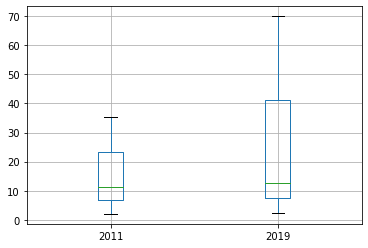

In [42]:
avgwlen11 = tweets2011.word_len.map(sum)/tweets2011.tweet_len
avgwlen19 = tweets2019.word_len.map(sum)/tweets2019.tweet_len
sum(avgwlen11)/len(tweets2011.word_len)
sum(avgwlen19)/len(tweets2019.word_len)

max11 = max(avgwlen11)
min11 = min(avgwlen11)

max19 = max(avgwlen19)
min19 = min(avgwlen19)

df = pd.DataFrame({'2011' : [avglen11, max11, min11], '2019' : [avglen19, max19, min19]}, index=['Average Tweet Length','Max Tweet Length','Min Tweet Length'] )
ax = df.boxplot()

These word clouds analyze sentiment with frequency of ngrams.

(-0.5, 399.5, 199.5, -0.5)

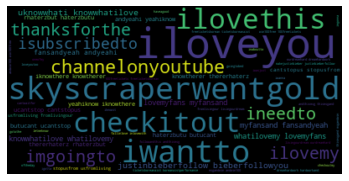

In [43]:
flat1gram11 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat1gram11.append(i)
            
pos = tweets2011[tweets2011.polarity == 'pos']
reemovNestings(pos.trigrams.tolist())

# Start with one review:
tmp = []
text = ""
for t in flat1gram11:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

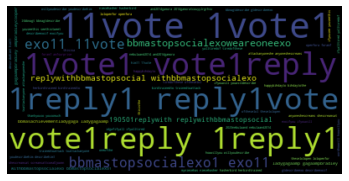

In [44]:
flat1gram19 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat1gram19.append(i)
            
pos = tweets2019[tweets2019.polarity == 'pos']
reemovNestings(pos.trigrams.tolist())

# Start with one review:
tmp = []
text = ""
for t in flat1gram19:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

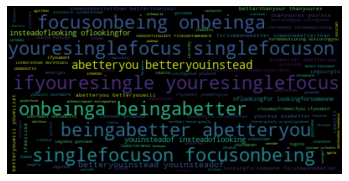

In [45]:
flat1gram11 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat1gram11.append(i)
            
pos = tweets2011[tweets2011.polarity == 'neg']
reemovNestings(pos.trigrams.tolist())

# Start with one review:
tmp = []
text = ""
for t in flat1gram11:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

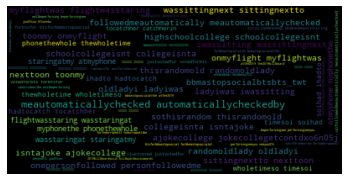

In [46]:
flat1gram19 = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            flat1gram19.append(i)
            
pos = tweets2019[tweets2019.polarity == 'neg']
reemovNestings(pos.trigrams.tolist())

# Start with one review:
tmp = []
text = ""
for t in flat1gram19:
    tmp = ''.join(t)
    text = text + ' ' + tmp

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()